# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [2]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
# Data augmentation for the training set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Data augmentation for the test set
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 64  

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

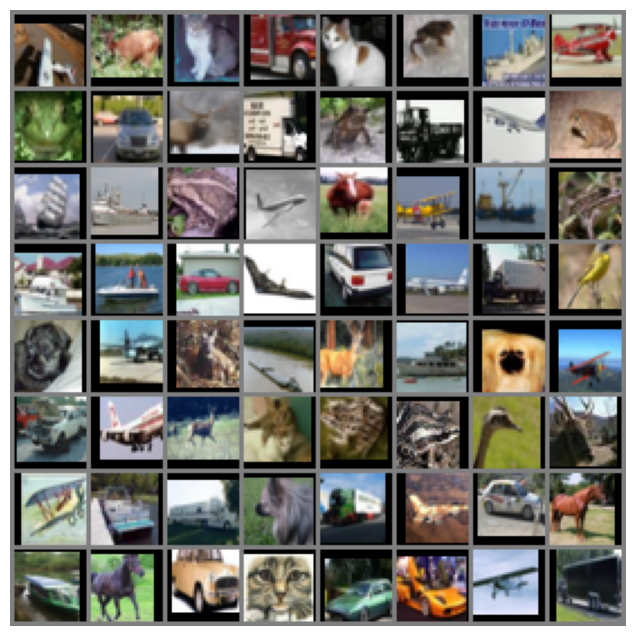

In [4]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [5]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout2 = nn.Dropout(0.4)

        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x
model = Model(n_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(model)

Model(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [6]:
loss_fn = nn.CrossEntropyLoss()  # Cross-Entropy Loss for classification
learning_rate = 0.001 
#optimiser = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4) 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.1)

## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [7]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[-0.5403733   0.08065753  0.13348718 -0.00976752 -0.5188596  -0.05648217
  -0.3744197  -0.8293939  -0.41596404 -0.549318  ]
 [ 0.44859484 -0.26168278 -0.4987831  -0.1540196   0.11773317 -0.6473258
   1.0417256   0.05982299  0.32163596  0.01597193]]
Output probabilities:
[[0.07564403 0.14076182 0.14839816 0.12859195 0.07728904 0.12272298
  0.08929916 0.05665713 0.08566529 0.07497043]
 [0.13339935 0.06556682 0.05172646 0.07301997 0.09582137 0.0445863
  0.24140552 0.09042995 0.11749414 0.0865502 ]]


In [9]:
num_epochs = 10
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        output = model(inputs)
        loss = loss_fn(output, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  
        step += 1
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            train_accuracies.append(np.mean(train_accuracies_batches))
            train_accuracies_batches = []
        
            # Compute accuracies on validation set
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()  # Set model to evaluation mode
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    
                    # Compute validation predictions and accuracy
                    predictions = output.max(1)[1]
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))
                
                model.train()  # Set model back to training mode
                
            # Append average validation accuracy to list
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")


Step 500     training accuracy: 0.47046875
             test accuracy: 0.6146
Step 1000    training accuracy: 0.645713876146789
             test accuracy: 0.7038
Step 1500    training accuracy: 0.662375
             test accuracy: 0.7062
Step 2000    training accuracy: 0.6961009174311926
             test accuracy: 0.7516
Step 2500    training accuracy: 0.7158076298701299
             test accuracy: 0.763
Step 3000    training accuracy: 0.72303125
             test accuracy: 0.7454
Step 3500    training accuracy: 0.7379872311827957
             test accuracy: 0.7897
Step 4000    training accuracy: 0.7536458333333333
             test accuracy: 0.8013
Step 4500    training accuracy: 0.75815625
             test accuracy: 0.8099
Step 5000    training accuracy: 0.7707487824675324
             test accuracy: 0.7939
Step 5500    training accuracy: 0.7644230769230769
             test accuracy: 0.8114
Step 6000    training accuracy: 0.7823125
             test accuracy: 0.8342
Step 6500    

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

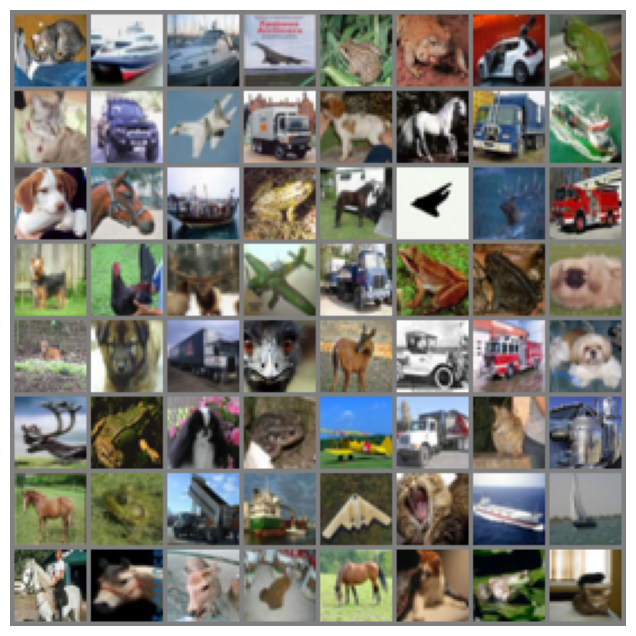

    TRUE        PREDICTED
-----------------------------
     cat          frog     
    ship          ship     
    ship          ship     
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          frog     
     cat           cat     
 automobile       truck    
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse         horse    
    ship          ship     
    frog          frog     
    horse         horse    
  airplane      airplane   
    deer          deer     
    truck         truck    
     dog          deer     
    bird          deer     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          bird     
     dog          bi

In [10]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [11]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [12]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.844


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


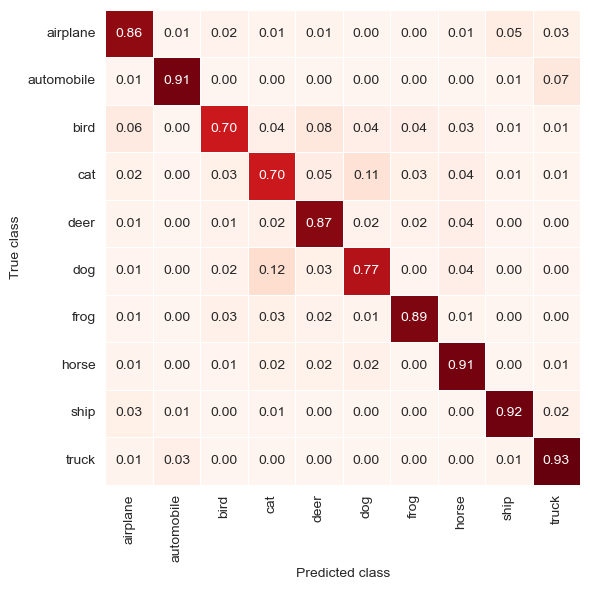

In [13]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

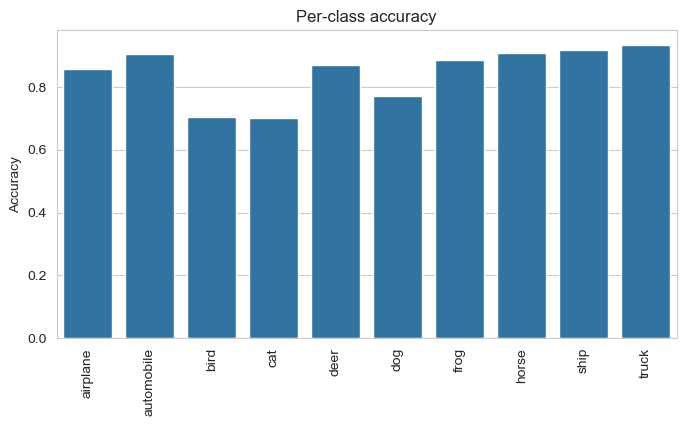

In [14]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

**Answer:** Yes, I was able to acheive an test accuracy of 84.4%. 

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

**Answer:** Initially, I had less denser network and was able to achieve test accuracy of around  64.9%. Then, I was going with SGD and SGD with momentum and L2 regularisation I was able to see the increase in accuracy but the model wasn't converging faster. So, I decided to go with Adam optimiser with L2 regularisation as it's good for convergence. But, I noticed that adam has faster convergence rate even with 0.001 learning rate which led to the overfitting of the model. I added a learning rate scheduler that would help exploring the model the Learning rates not just faster convergence even then the overfitting persisted. So, Now I did data augmentation to diversify the train data to avoid overfitting. I did random horizontal flip and Random Crop to the existing normalisation. This led to the system training a more complex model with the diversified train data and was able to get better test accuracy as the model was trained on more complex data. 


3. Write down key lessons/insights you got during this exercise.

**Answer:**

Insights: 
- When the model is deeper it the accuracy increases but when you increase it further it saturates and reduces the test accuracy and also overfits.
- Adam accelerates training with adaptive learning rates for faster convergence, while SGD provides stable updates and better generalization by exploring the parameter space and reducing overfitting. 
- Data augmentation is a good method to avoid overfitting and improving test accuracy.
- The batch normalisation and dropout are pretty helpful when it comes to making sure the batch data is uniform and that the model doesn't rely on certain weights. 

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [15]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: ['NVIDIA GeForce GTX 1660 Ti with Max-Q Design']


You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

Try creating a network with just two layers - an input and an output layer, no hidden layer - with 784 and 10 neurons, respectively. Train the network using stochastic gradient descent. What classification accuracy can you achieve? (MINST dataset)

**Answer:**





In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

In [3]:
mnist_trainset = MNIST("./temp/", train=True, download=True)
mnist_testset = MNIST("./temp/", train=False, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:26<00:00, 371084.39it/s]


Extracting ./temp/MNIST\raw\train-images-idx3-ubyte.gz to ./temp/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 222375.05it/s]


Extracting ./temp/MNIST\raw\train-labels-idx1-ubyte.gz to ./temp/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:07<00:00, 219519.54it/s]


Extracting ./temp/MNIST\raw\t10k-images-idx3-ubyte.gz to ./temp/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 31350.84it/s]


Extracting ./temp/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./temp/MNIST\raw



In [19]:
# To speed up training we'll only work on a subset of the data
x_train = mnist_trainset.data[:1000].view(-1, 784).float()
targets_train = mnist_trainset.targets[:1000]

x_valid = mnist_trainset.data[1000:1500].view(-1, 784).float()
targets_valid = mnist_trainset.targets[1000:1500]

x_test = mnist_testset.data[:500].view(-1, 784).float()
targets_test = mnist_testset.targets[:500]

# Normalize the inputs
x_train.div_(255)
x_valid.div_(255)
x_test.div_(255)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [17]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(784, 10)  
    def forward(self, x):
        return self.fc(x)
    
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)



In [18]:
num_epochs = 10
batch_size = 128
train_loader = DataLoader(list(zip(x_train, targets_train)), batch_size=batch_size, shuffle=True)
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
with torch.no_grad():
    valid_outputs = model(x_valid)
    _, predicted = torch.max(valid_outputs, 1)
    valid_accuracy = (predicted == targets_valid).float().mean()
    print(f'Validation Accuracy: {valid_accuracy.item() * 100:.2f}%')
with torch.no_grad():
    test_outputs = model(x_test)
    _, predicted = torch.max(test_outputs, 1)
    test_accuracy = (predicted == targets_test).float().mean()
    print(f'Test Accuracy: {test_accuracy.item() * 100:.2f}%')

Epoch [1/10], Loss: 2.3048
Epoch [2/10], Loss: 2.3009
Epoch [3/10], Loss: 2.2742
Epoch [4/10], Loss: 2.2756
Epoch [5/10], Loss: 2.2593
Epoch [6/10], Loss: 2.2844
Epoch [7/10], Loss: 2.2722
Epoch [8/10], Loss: 2.2310
Epoch [9/10], Loss: 2.2354
Epoch [10/10], Loss: 2.2470
Validation Accuracy: 21.20%
Test Accuracy: 16.80%


It's evident that the model feels difficulty in learning data as it doesn't have any hidden layer. The observed loss values indicate that the neural network, consisting of only an input layer (784 neurons) and an output layer (10 neurons), is struggling to learn from the MNIST dataset, as it shows minimal improvement in loss and very low validation (21.20%) and test (16.80%) accuracy. This poor performance can be attributed to the lack of hidden layers, which limits the model's capacity to capture complex patterns. To improve accuracy, it's advisable to add hidden layers, incorporate activation functions, adjust the learning rate, and consider increasing the number of epochs for training.